In [1]:
import numpy as np
import pandas as pd
from cmdstanpy import cmdstan_path, CmdStanModel
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
import arviz as az
import statsmodels.api as sm
import tqdm

from datamodel import SPX, StockData
from model_testing import create_lags

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

In [ ]:
spx = SPX()
vix_data = StockData(["^VIX"])

In [327]:
spx_wk_prices = spx.prices.resample("W-FRI").last()
spx_wk_returns = (np.log(spx_wk_prices) - np.log(spx_wk_prices.shift(1))).dropna()
vix_wk_prices = vix_data.prices.VIX["close"].resample("W-FRI").last()
spx_wk_vol = np.sqrt(spx.vol.resample("W-FRI").sum())

wk_returns_lags = create_lags(spx_wk_returns, 4, "wk_returns")
wk_vix_lags = create_lags(vix_wk_prices, 4, "wk_vix")
wk_vol_lags = create_lags(spx_wk_vol, 4, "wk_vol")

d_spx_returns = (np.log(spx.prices) - np.log(spx.prices.shift(1))).dropna()
d_returns_lags = create_lags(d_spx_returns, 21, "d_returns")
d_vix_lags = create_lags(vix_data.prices.VIX["close"], 21, "d_vix")
d_vol_lags = create_lags(np.sqrt(spx.vol), 21, "d_vol")

x = pd.concat([wk_returns_lags, np.log(wk_vix_lags), np.log(wk_vol_lags), d_returns_lags, np.log(d_vix_lags), np.log(d_vol_lags)], axis=1).dropna()
y = np.log(spx_wk_vol).shift(-1).dropna()

common_index = x.index.intersection(y.index)
x = x.loc[common_index]
y = y.loc[common_index]

In [249]:
model_spec = """
    data {
        int N;  // Number of observations
        int p;  // Number of variables
        vector[N] y;  // Dependent variable
        matrix[N, p] x;  // Independent variables
    }
    parameters {
        real mu;
        vector[p] beta;
        real<lower=0> rho;
        real<lower=0> sigma;
    }
    model {
        mu ~ normal(0, 10);
        rho ~ normal(0, 1);
        beta ~ normal(0, rho);
        sigma ~ normal(0, 10);
        
        y ~ student_t(10, mu + x * beta, sigma);
    }
    generated quantities {
        real y_tilde[N];
        y_tilde = student_t_rng(10, mu + x * beta, sigma);
    }
    """
with open("./stan_model/model.stan", "w") as file:
    file.write(model_spec)

model = CmdStanModel(stan_file="./stan_model/model.stan")

INFO:cmdstanpy:compiling stan program, exe file: /home/eadains/VolatilityTrading/stan_model/model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/eadains/VolatilityTrading/stan_model/model


In [328]:
data = {"N": len(y),
        "p": len(x.columns),
        "y": y.values,
        "x": x.values}
sample = model.sample(data=data, output_dir="./stan_model", iter_warmup=1000, iter_sampling=2500, show_progress=True, inits=0)

Chain 1 - warmup:   0%|                                                                                                                                                       | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|                                                                                                                                                       | 0/1 [00:00<?, ?it/s]


Chain 2 - warmup:   0%|                                                                                                                                                    | 0/3500 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|                                                                                                                                                       | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|                                                                                                                                                    | 0/3500 [00:00<?, ?it/s]


Chain 4 

Chain 2 - sample:  29%|███████████████████████████████████████▏                                                                                                 | 1000/3500 [00:59<02:31, 16.54it/s]


Chain 4 - warmup:  29%|███████████████████████████████████████▏                                                                                                 | 1000/3500 [00:58<02:33, 16.31it/s]


Chain 1 - sample:  31%|███████████████████████████████████████████                                                                                              | 1100/3500 [01:05<02:31, 15.80it/s]

Chain 2 - sample:  31%|███████████████████████████████████████████                                                                                              | 1100/3500 [01:06<02:32, 15.76it/s]


Chain 1 - sample:  34%|██████████████████████████████████████████████▉                                                                                          | 1200/3500 [01:12<02:32, 15.07it/s]

Chain 2

Chain 1 - sample:  66%|██████████████████████████████████████████████████████████████████████████████████████████                                               | 2300/3500 [02:31<01:25, 14.05it/s]


Chain 4 - sample:  66%|██████████████████████████████████████████████████████████████████████████████████████████                                               | 2300/3500 [02:32<01:24, 14.13it/s]

Chain 1 - sample:  69%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2400/3500 [02:38<01:17, 14.12it/s]


Chain 4 - sample:  69%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2400/3500 [02:39<01:17, 14.25it/s]

Chain 1 - sample:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2500/3500 [02:45<01:10, 14.12it/s]


Chain 4

Chain 4 -   done: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3500/3500 [04:00<00:00, 14.57it/s]


In [329]:
arviz_data = az.from_cmdstanpy(
    posterior=sample,
    posterior_predictive="y_tilde",
    observed_data={"y": y.values}
)

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'rho'}>,
        <AxesSubplot:title={'center':'rho'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

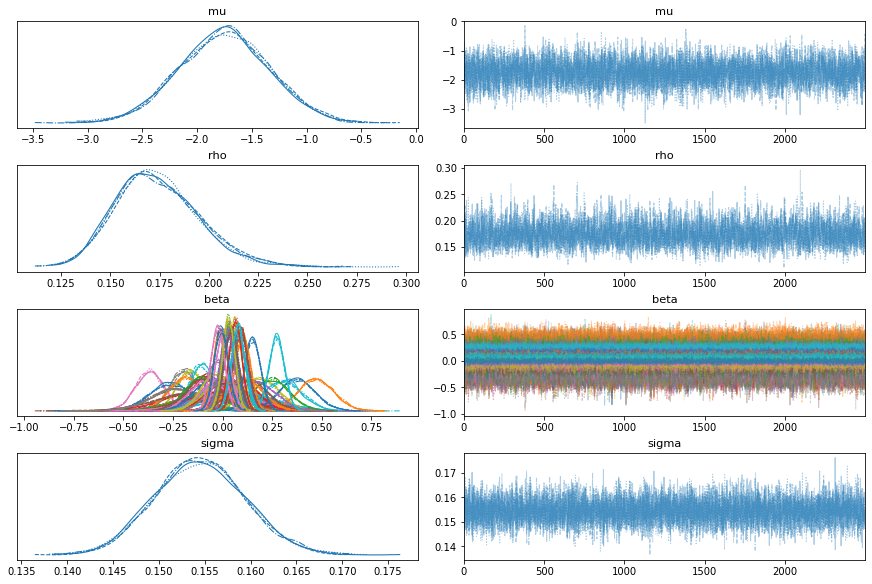

In [330]:
az.plot_trace(arviz_data, compact=True, var_names=["mu", "rho", "beta", "sigma"])

In [331]:
y_tilde = arviz_data.posterior_predictive.y_tilde.values.reshape(10000, -1)
residuals = y.values - np.mean(y_tilde, axis=0)
mean = np.mean(y_tilde, axis=1)
std = np.std(y_tilde, axis=1)
skew = stats.skew(y_tilde, axis=1)
kurt = stats.kurtosis(y_tilde, axis=1)

Text(0.5, 1.0, 'Kurtosis')

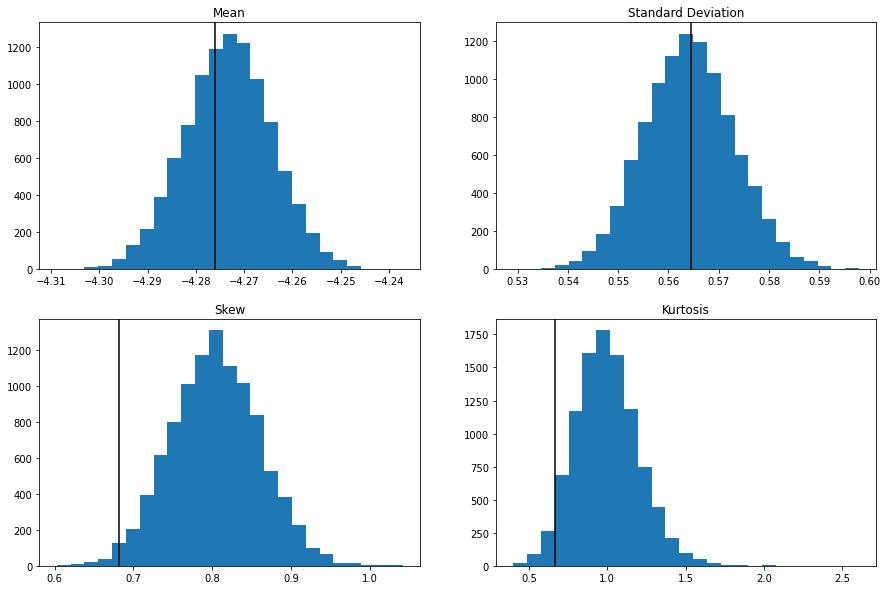

In [332]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(mean, bins=25)
axs[0, 0].axvline(np.mean(y), color='black')
axs[0, 0].set_title("Mean")
axs[0, 1].hist(std, bins=25)
axs[0, 1].axvline(np.std(y), color='black')
axs[0, 1].set_title("Standard Deviation")
axs[1, 0].hist(skew, bins=25)
axs[1, 0].axvline(stats.skew(y), color='black')
axs[1, 0].set_title("Skew")
axs[1, 1].hist(kurt, bins=25)
axs[1, 1].axvline(stats.kurtosis(y), color='black')
axs[1, 1].set_title("Kurtosis")

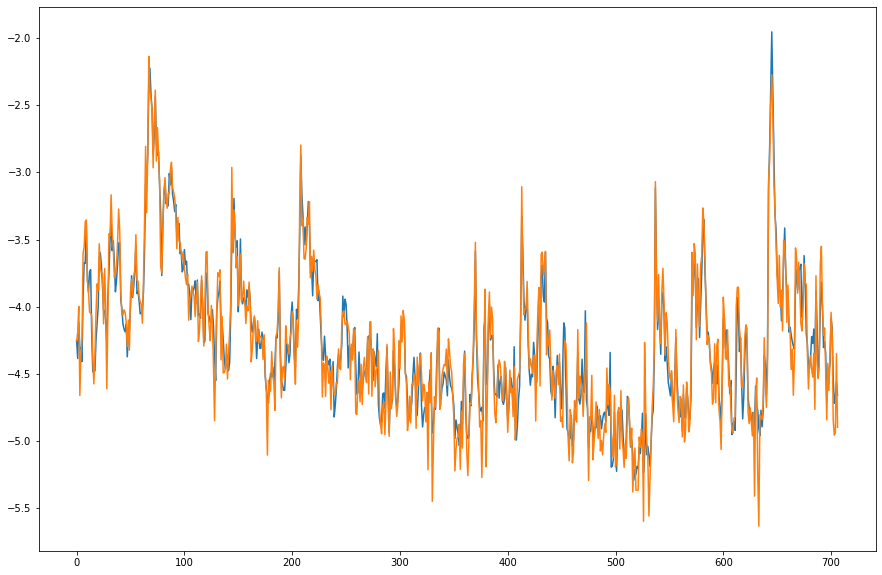

In [333]:
plt.plot(np.mean(y_tilde, axis=0))
plt.plot(y.values)

In [334]:
# 95% bounds exceedences
np.sum(y.values > np.percentile(y_tilde, 95, axis=0)) / len(y.values)

0.03818953323903819

In [335]:
# 5% bounds exceedences
np.sum(y.values < np.percentile(y_tilde, 5, axis=0)) / len(y.values)

0.04384724186704385

<AxesSubplot:xlabel='y / y_tilde'>

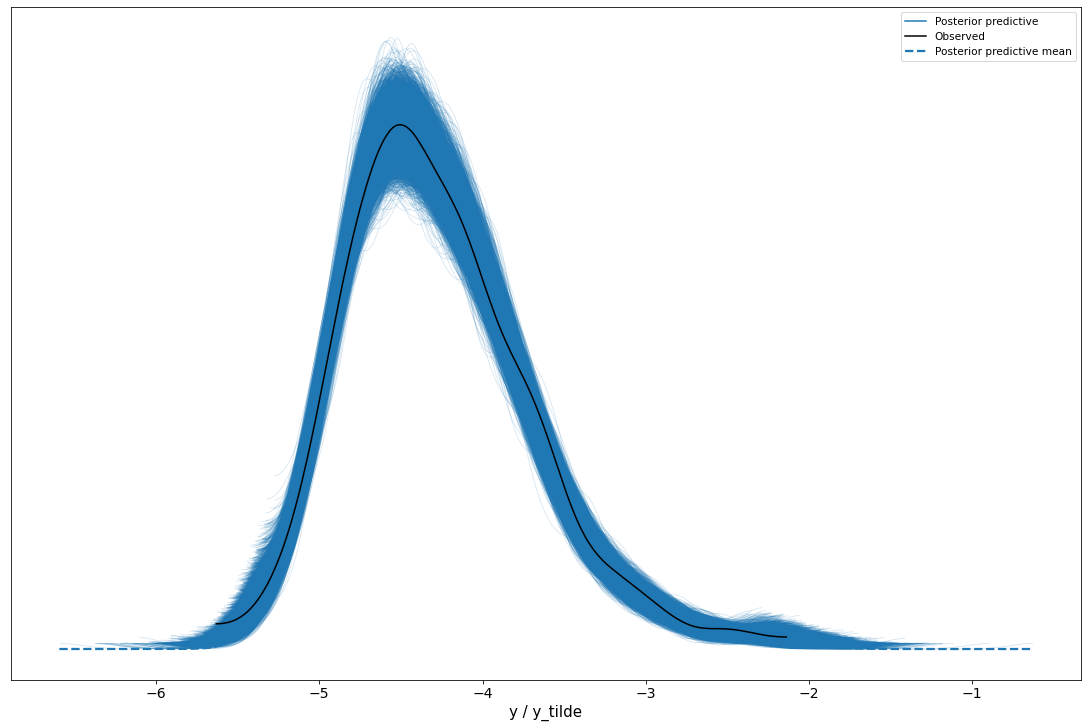

In [336]:
az.plot_ppc(arviz_data, data_pairs={"y": "y_tilde"})

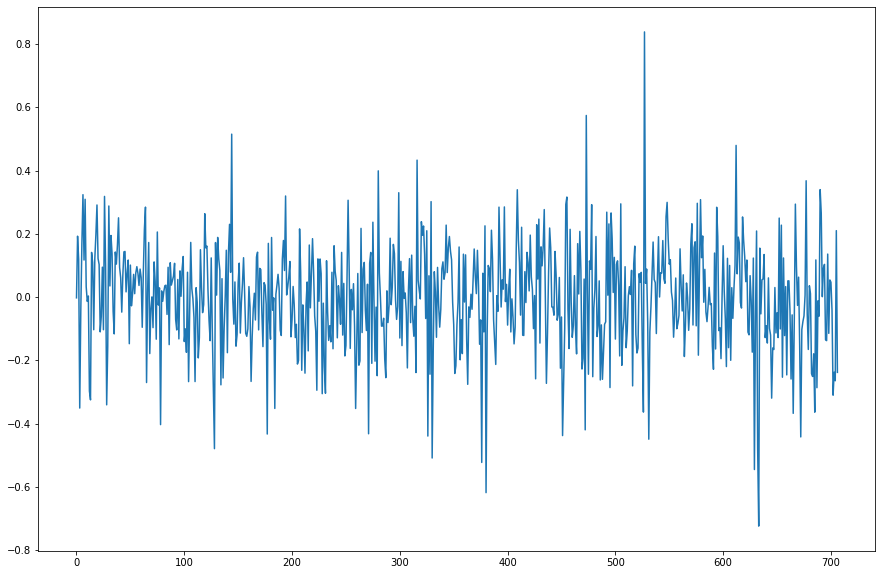

In [337]:
plt.plot(residuals)

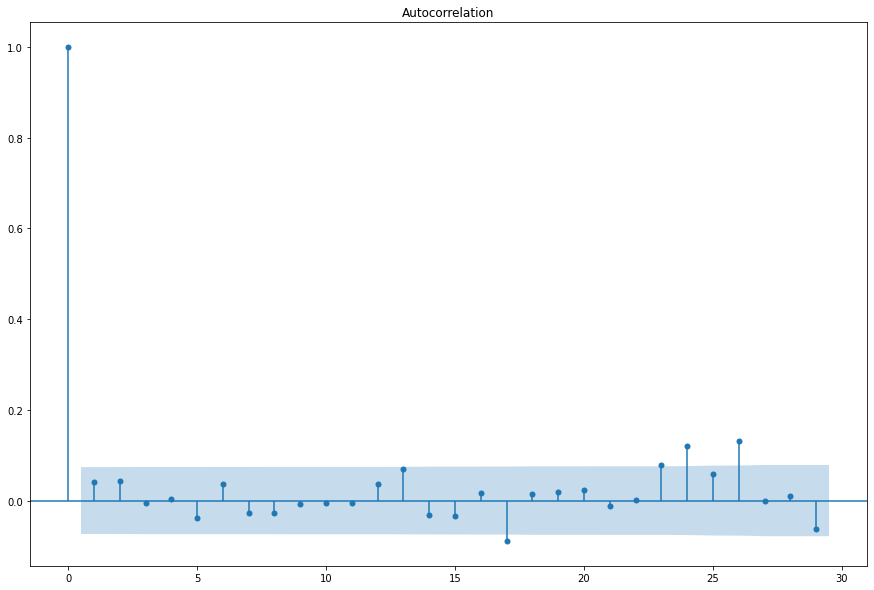

In [338]:
acf = sm.tsa.graphics.plot_acf(residuals)

In [339]:
values = []

for t in range(len(y)):
    ecdf = sm.distributions.empirical_distribution.ECDF(y_tilde[:, t])
    values.append(ecdf(y.iloc[t]))

In [340]:
stats.kstest(values, "uniform")

KstestResult(statistic=0.03511697312588402, pvalue=0.33996312853874655)